## Setup

In [1]:
!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 792 (delta 11), reused 31 (delta 11), pack-reused 753
Receiving objects: 100% (792/792), 55.00 MiB | 11.34 MiB/s, done.
Resolving deltas: 100% (462/462), done.
/content/semantic-segmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/semantic-segmentation
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 237 kB 61.8 MB/s 
     |████████████████████████████████| 42 kB 954 kB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=eb7042b5f3097ce2503d002c1a6ba4102138d105fa3e53af0ce6fbb736300e25
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e4

In [2]:
import torch
from torchvision import io
from torchvision import transforms as T
from PIL import Image

def show_image(image):
    if image.shape[2] != 3: image = image.permute(1, 2, 0)
    image = Image.fromarray(image.numpy())
    return image

## Show Available Pretrained Models

In [3]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


## Load a Pretrained Model

Download a pretrained model's weights from the result table (ADE20K, CityScapes, ...) and put it in `checkpoints/pretrained/model_name/`.

In [4]:
%pip install -U gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.3-py3-none-any.whl size=14841 sha256=7f2a87011e6454ae863df2d8bb2593c72e9f541800e16506d239e5ab6b304a60
  Stored in directory: /root/.cache/pip/wheels/94/8d/0b/bdcd83555c3555f91a33f6c2384428d9f163c7d75ab0d272b4
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [5]:
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT
To: /content/semantic-segmentation/checkpoints/pretrained/segformer/segformer.b3.ade.pth
100%|██████████| 190M/190M [00:07<00:00, 26.9MB/s]


'./checkpoints/pretrained/segformer/segformer.b3.ade.pth'

In [6]:
from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B3',
    num_classes=150
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

print('Loaded Model')

Loaded Model


## Simple Image Inference

### Load Image

In [18]:
!wget -O assests/demo2.jpg https://louisvilleky.gov/sites/default/files/2021-06/resized-image-promo.jpeg

--2022-10-18 20:38:43--  https://louisvilleky.gov/sites/default/files/2021-06/resized-image-promo.jpeg
Resolving louisvilleky.gov (louisvilleky.gov)... 104.18.23.213, 104.18.22.213, 2606:4700::6812:17d5, ...
Connecting to louisvilleky.gov (louisvilleky.gov)|104.18.23.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 991190 (968K) [image/jpeg]
Saving to: ‘assests/demo2.jpg’

assests/demo2.jpg   100%[===================>] 967.96K  --.-KB/s    in 0.03s   

2022-10-18 20:38:43 (37.5 MB/s) - ‘assests/demo2.jpg’ saved [991190/991190]



torch.Size([3, 1414, 2500])


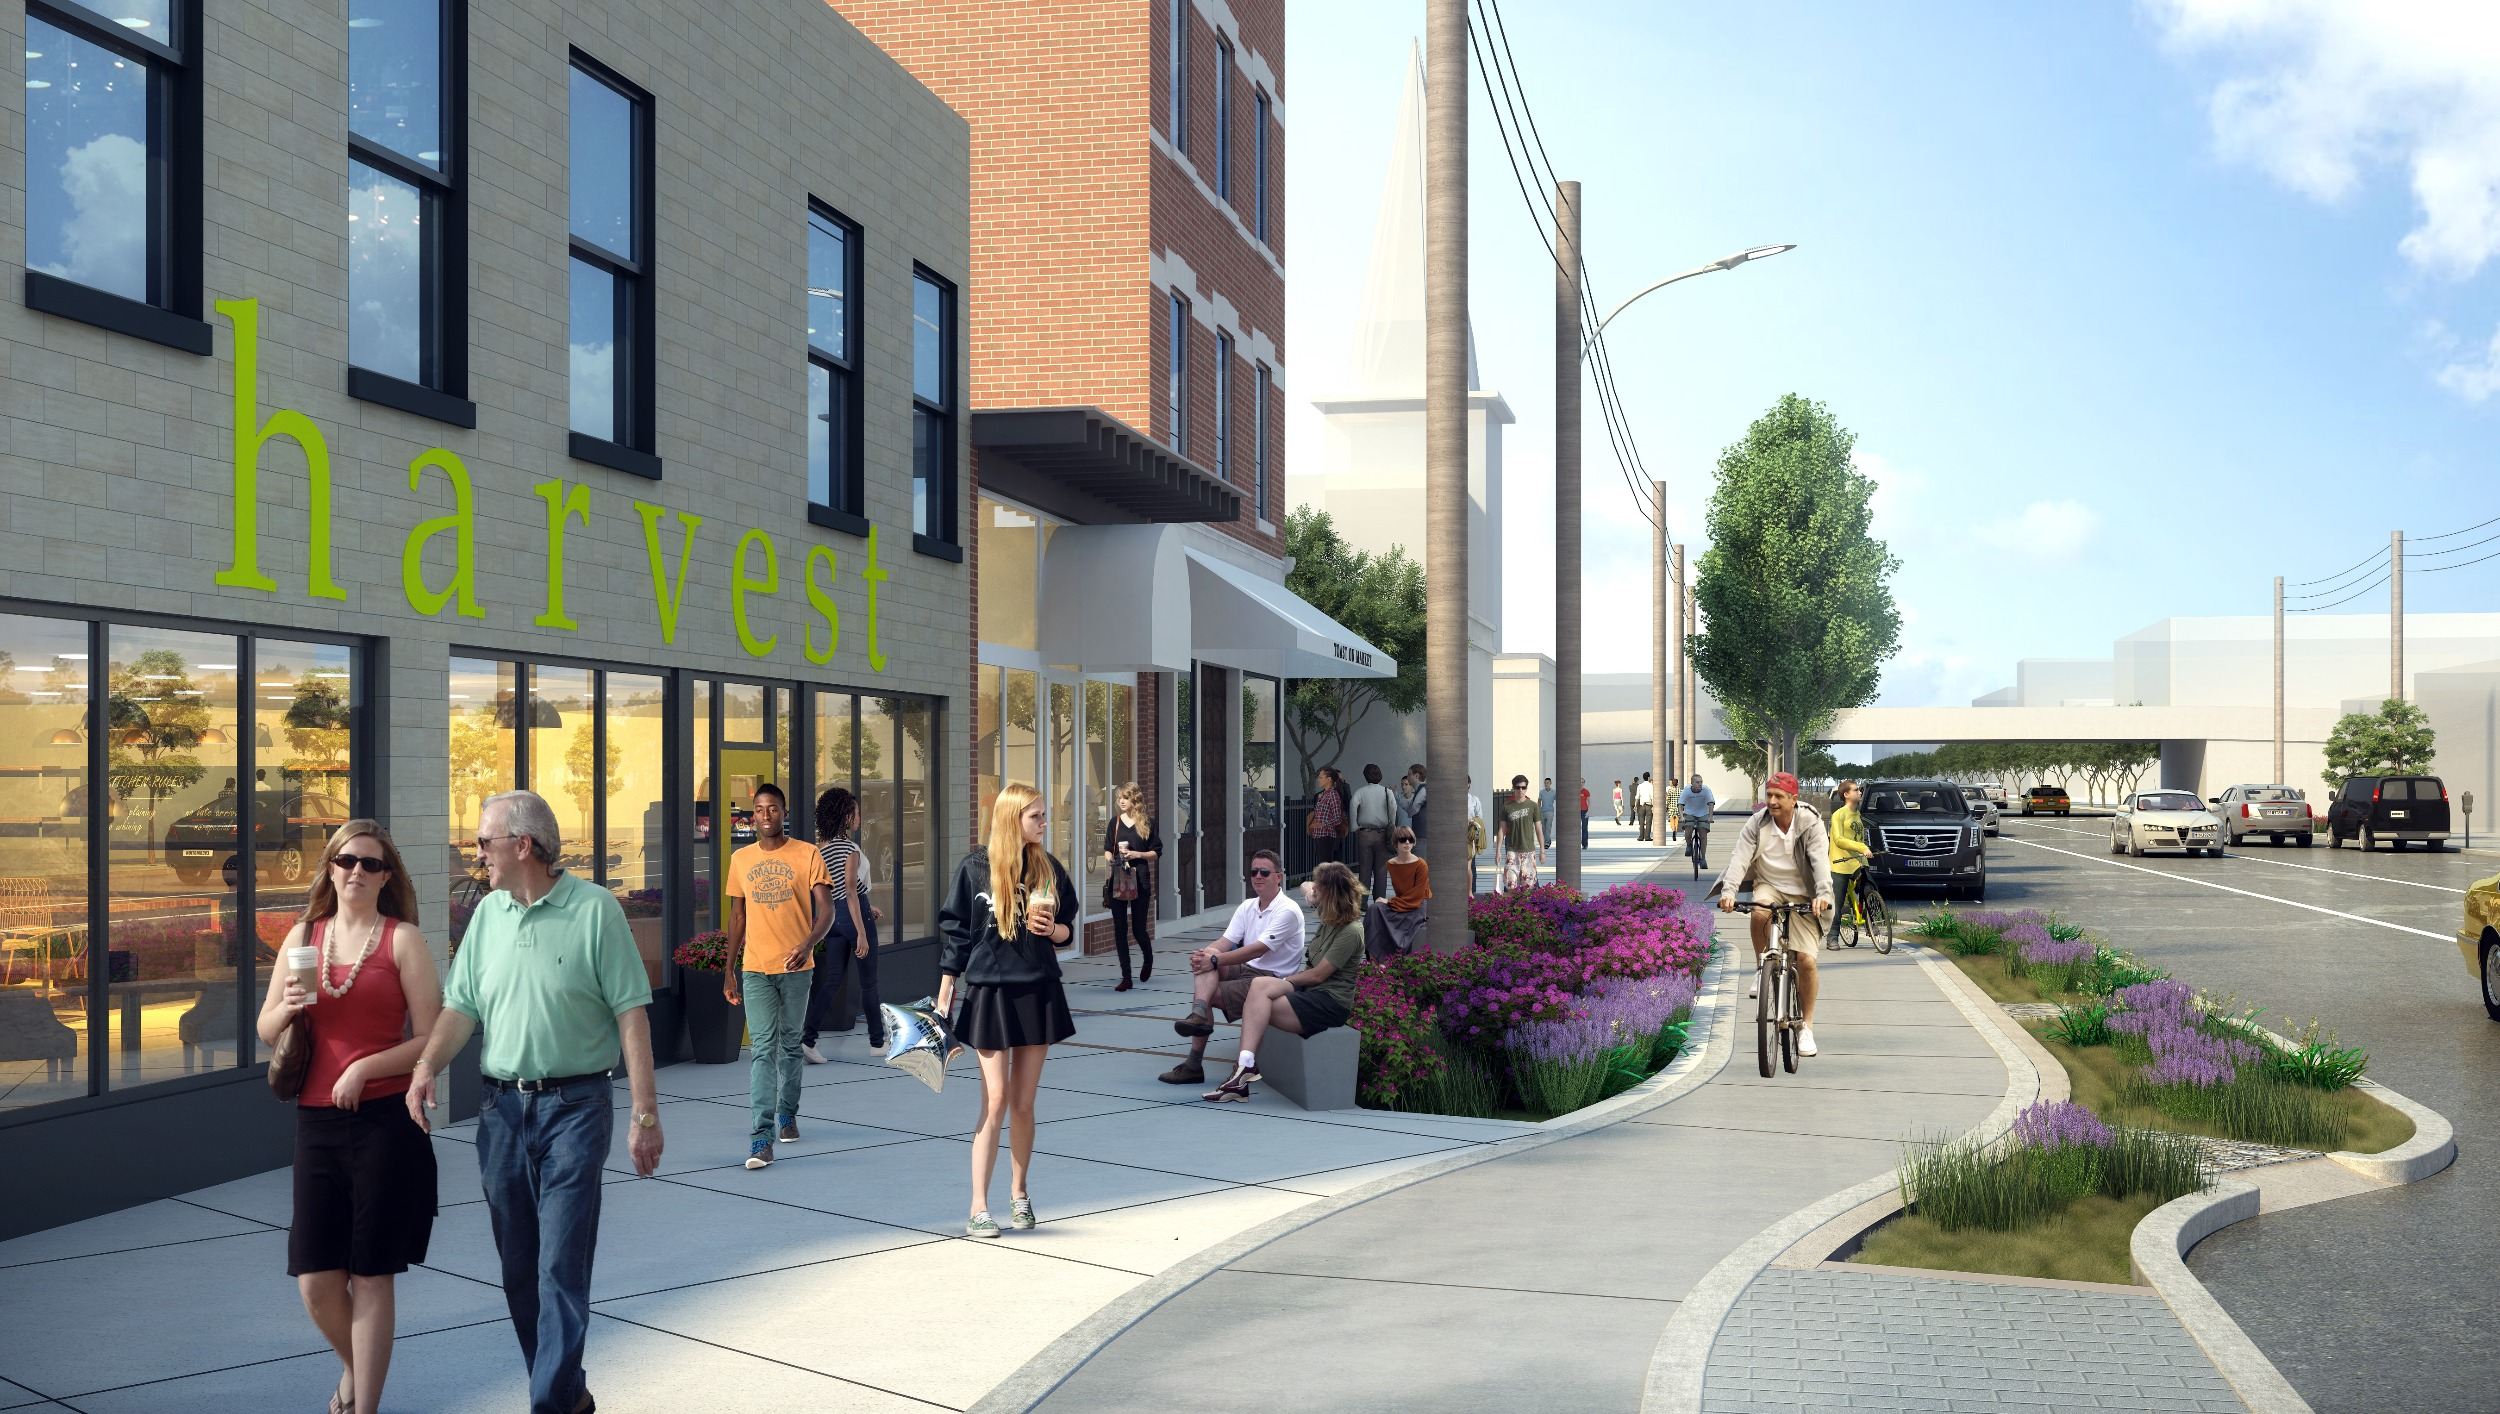

In [43]:
#image_path = './assests/ade/ADE_val_00000049.jpg'
image_path = './assests/demo2.jpg'
image = io.read_image(image_path)
print(image.shape)
show_image(image)

### Preprocess

In [44]:
# resize
#image = T.CenterCrop((512, 512))(image)
image = T.CenterCrop((1400, 2500))(image)
# scale to [0.0, 1.0]
image = image.float() / 255
# normalize
image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
# add batch size
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 1400, 2500])

### Model Forward

In [45]:
with torch.inference_mode():
    seg = model(image)
seg.shape

torch.Size([1, 150, 1400, 2500])

### Postprocess

In [46]:
seg = seg.softmax(1).argmax(1).to(int)
seg.unique()

tensor([  0,   1,   2,   4,   6,   9,  11,  12,  13,  17,  20,  32,  38,  41,
         42,  43,  53,  59,  72,  87,  93, 115, 125, 127, 136])

In [47]:
from semseg.datasets import *

palette = eval('ADE20K').PALETTE

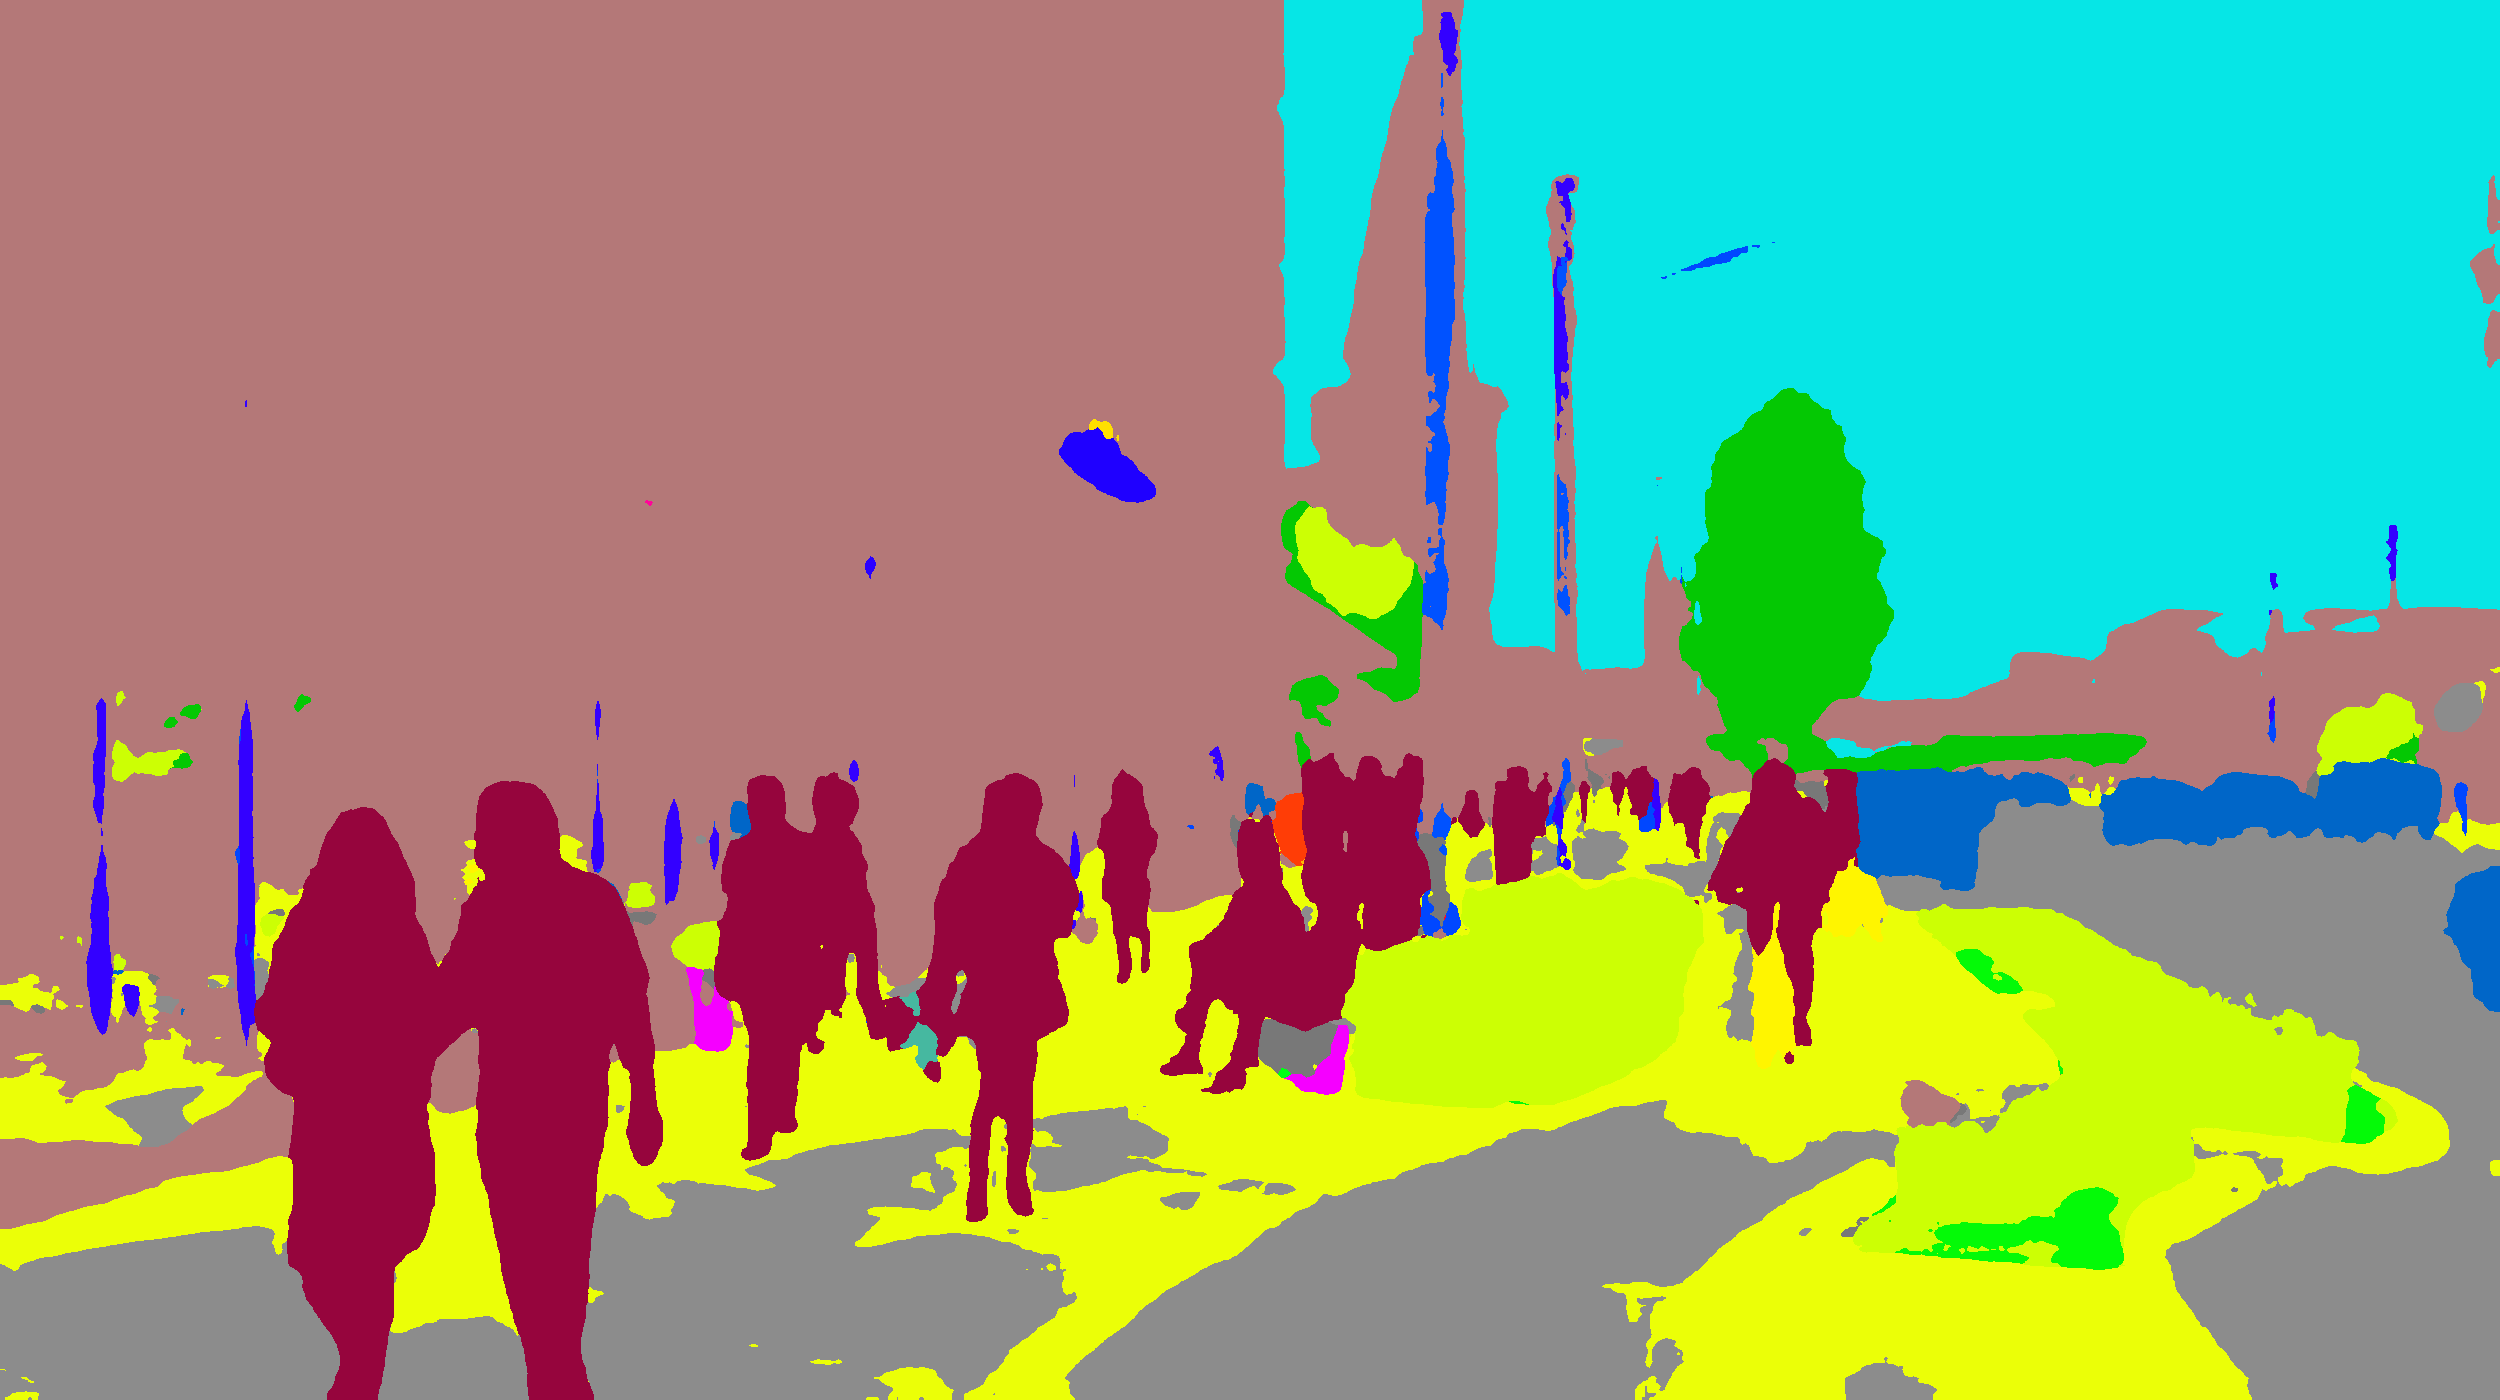

In [48]:
seg_map = palette[seg].squeeze().to(torch.uint8)
show_image(seg_map)

## Show Available Backbones

In [49]:
from semseg import show_backbones

show_backbones()

Backbone Names    Variants
----------------  ------------------------------------
ResNet            ['18', '34', '50', '101', '152']
ResNetD           ['18', '50', '101']
MicroNet          ['M1', 'M2', 'M3']
MobileNetV2       ['1.0']
MobileNetV3       ['S', 'L']
MiT               ['B0', 'B1', 'B2', 'B3', 'B4', 'B5']
PVTv2             ['B1', 'B2', 'B3', 'B4', 'B5']
ResT              ['S', 'B', 'L']
PoolFormer        ['S24', 'S36', 'M36']
ConvNeXt          ['T', 'S', 'B']


## Show Available Heads

In [50]:
from semseg import show_heads

show_heads()

  No.  Heads
-----  -------------
    1  UPerHead
    2  SegFormerHead
    3  SFHead
    4  FPNHead
    5  FaPNHead
    6  FCNHead
    7  CondHead
    8  LawinHead


## Show Available Datasets

In [51]:
from semseg import show_datasets

show_datasets()

  No.  Datasets
-----  ---------------
    1  CamVid
    2  CityScapes
    3  ADE20K
    4  MHPv1
    5  MHPv2
    6  LIP
    7  CIHP
    8  CCIHP
    9  ATR
   10  PASCALContext
   11  COCOStuff
   12  SUIM
   13  SunRGBD
   14  MapillaryVistas
   15  HELEN
   16  LaPa
   17  iBugMask
   18  CelebAMaskHQ
   19  FaceSynthetics


## Construct a Custom Model

### Choose a Backbone

In [ ]:
from semseg.models.backbones import ResNet

backbone = ResNet('18')

In [ ]:
# init random input batch
x = torch.randn(2, 3, 224, 224)

In [ ]:
# get features from the backbone
features = backbone(x)
for out in features:
    print(out.shape)

### Choose a Head

In [ ]:
from semseg.models.heads import UPerHead

head = UPerHead(backbone.channels, 128, num_classes=10)

In [ ]:
seg = head(features)
seg.shape

In [ ]:
from torch.nn import functional as F
# upsample the output
seg = F.interpolate(seg, size=x.shape[-2:], mode='bilinear', align_corners=False)
seg.shape

Check `semseg/models/custom_cnn.py` and `semseg/models/custom_vit.py` for a complete construction for custom model.